In [1]:
# Trains the structure-sequence hybrid predictor for classification


# Authored by Aidan Riley 7/1/22

import sys
sys.path.insert(1,'../src')
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import util
import GA_util
import keras.layers
print('loaded tf',tf.__version__)

loaded tf 2.11.0


In [3]:
#load the real data, data with just an RBS loop, just a start codon, and data that binds to itself

num_samples = 8000

real_data= np.load('../data/Toehold_data/collins_encoded.npy')
real_data = real_data[:,:,1:]

random_indices = np.random.choice(np.arange(0,real_data.shape[0]), size=num_samples, replace=False)

real_data = real_data[random_indices,:,:]

rbs_data = GA_util.create_rbs_data(8000)
aug_data = GA_util.create_aug_data(8000)
rbs_aug_data = GA_util.create_rbs_aug_data(8000)
binding_data = GA_util.create_binding_data(8000)


full_dataset = np.concatenate((real_data,rbs_data,aug_data,rbs_aug_data,binding_data),axis=0)
y = np.zeros((full_dataset.shape[0],5))

print(full_dataset.shape)
print(y.shape)




(8000, 4, 18)
(40000, 4, 59)
(40000, 5)


In [4]:
#Assign one-hot encoded labels
# y[:real_data.shape[0]] = 1
# y[real_data.shape[1]:] = 0
y[:real_data.shape[0],0] = 1
y[real_data.shape[0]:real_data.shape[0]+rbs_data.shape[0],1] = 1
y[real_data.shape[0]+rbs_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0],2] = 1
y[real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]+rbs_aug_data.shape[0],3] = 1
y[-rbs_aug_data.shape[0]:,4] = 1

print(np.sum(y[:,0]))
print(np.sum(y[:,1]))
print(np.sum(y[:,2]))
print(np.sum(y[:,3]))
print(np.sum(y[:,4]))

8000.0
8000.0
8000.0
8000.0
8000.0


In [5]:
ppms = GA_util.prototype_ppms_fast(full_dataset)
print(ppms.shape)

(40000, 59, 59)


In [6]:
letters = GA_util.unencode(full_dataset[0])

In [7]:
letters

'AATACTCTGTAACCGGCTCACACTTTGGGTAACAGAGGAGAACCCAAATGGTGAGCCGG'

In [8]:
import nupack as n

mod = n.Model()

print(n.mfe(letters,mod))

[StructureEnergy(Structure('............(((((((((..(((((((...........)))))))..)))))))))'), energy=-26.976573944091797, stack_energy=-26.749998092651367)]


In [9]:
print('.'*len('............(((((((((((.((((((...........)))))).)))))))))))'))

...........................................................


In [10]:
print(n.defect(strands=letters,structure='...........................................................',model=mod))

0.5697498008472375


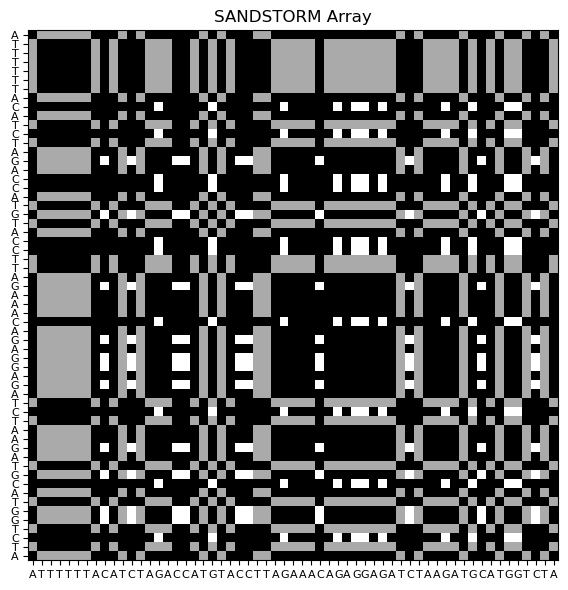

In [28]:
plt.figure(figsize=(7,6))
plt.title('SANDSTORM Array')
plt.imshow(ppms[0,:,:],cmap='gray')
plt.xticks(np.arange(0,len(letters)),labels=[letter for letter in letters],fontsize=8)
plt.yticks(np.arange(0,len(letters)),labels=[letter for letter in letters],fontsize=8)
plt.tight_layout()
plt.savefig('../figures/ppm_with_letters.svg',transparent=True,dpi=1000)

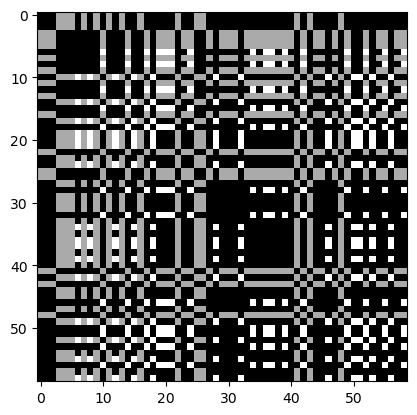

In [8]:
for i in range(3):
    plt.imshow(ppms[i,:,:],cmap='gray')
    # plt.savefig('../figures/ppms_%s.svg'%(i),transparent=True)

In [11]:
indices = np.arange(0,full_dataset.shape[0])
from sklearn.model_selection import train_test_split
seq_train,seq_test,ppm_train,ppm_test,y_train,y_test,train_indices,test_indices= train_test_split(full_dataset,ppms,y,indices,test_size=0.25) #Split w.r.t. ON value distribution


print(seq_train.shape)
print(ppm_train.shape)
print(y_train.shape)
print(seq_test.shape)
print(ppm_test.shape)
print(y_test.shape)

(30000, 4, 59)
(30000, 59, 59)
(30000, 5)
(10000, 4, 59)
(10000, 59, 59)
(10000, 5)


In [12]:
from keras import layers
from GA_util import GumbelSoftmax

latent_dim = 16
batch_size = 64
act = 'linear'

input_seqs = keras.Input(shape=(4,59,1))

input_probs = keras.Input(shape=(59,59,1))


#### Predictive Model Definition ####

#Sequence Branch
a = layers.Conv2D(latent_dim, (4, 30), strides=(4, 1), padding="same",activation=act)(input_seqs)
a = layers.BatchNormalization()(a)
a = layers.Conv2D(latent_dim/8, (4, 9), strides=(4, 1), padding="same",activation=act)(a)
a = layers.Conv2D(latent_dim/16,(4,3),strides=(4,1),padding='same',activation=act)(a)
a = layers.Flatten()(a)

b = layers.Dense(5,name='classification_output')(a)

discriminator_sequence  = keras.Model(inputs=input_seqs,outputs=[b],name='discriminator_sequence')
discriminator_sequence.summary()

#### Ensemble Model Definition ####

#Same as sequence, but fewer parameters
c = layers.Conv2D(latent_dim/16, (4, 18), strides=(4, 1), padding="same",activation=act)(input_seqs)
c = layers.BatchNormalization()(c)
c = layers.Conv2D(latent_dim/16, (4, 9), strides=(4, 1), padding="same",activation=act)(c)
c = layers.Conv2D(latent_dim/16,(4,3),strides=(4,1),padding='same',activation=act)(c)
c = layers.Flatten()(c)

# Additional PPM Branch 
d = layers.Conv2D(latent_dim/16, (8, 8), strides=(2, 2), padding="same",activation=act)(input_probs)
d = layers.BatchNormalization()(d)
d = layers.Conv2D(latent_dim/16, (4, 4), strides=(2, 2), padding="same",activation=act)(d)
d = layers.Conv2D(latent_dim/16,(2,2),strides=(2,2),padding='same',activation=act)(d)
d = layers.Flatten()(d)


e = layers.Concatenate()([c,d])
# c = layers.Dense(10)(c)
e = layers.Dense(5,name='classification_output')(e)


discriminator_ensemble = keras.Model(inputs=[input_seqs,input_probs],outputs=[e])
discriminator_ensemble.summary()

Metal device set to: Apple M1 Ultra


2025-03-18 18:34:40.184781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 18:34:40.184805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "discriminator_sequence"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 59, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 59, 16)         1936      
                                                                 
 batch_normalization (BatchN  (None, 1, 59, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 59, 2)          1154      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 59, 1)          25        
                                                                 
 flatten (Flatten)           (None, 59)                0         
                                            

In [14]:
#Train the Sequence Only Model

discriminator_sequence.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=5
hist = discriminator_sequence.fit(
    seq_train,y_train,batch_size=64,validation_data=[seq_test,y_test],epochs=epochs)

Epoch 1/5


2025-03-18 18:34:51.425359: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-18 18:34:51.653795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.6892

2025-03-18 18:34:59.685135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 13ms/step - loss: 0.7114 - accuracy: 0.6892 - val_loss: 0.4172 - val_accuracy: 0.8193
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.3451 - accuracy: 0.8516 - val_loss: 0.3032 - val_accuracy: 0.8700
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.2764 - accuracy: 0.8792 - val_loss: 0.2550 - val_accuracy: 0.8842
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.2567 - accuracy: 0.8882 - val_loss: 0.2462 - val_accuracy: 0.8877
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.2445 - accuracy: 0.8916 - val_loss: 0.2686 - val_accuracy: 0.8885


In [15]:
#Train the Dual Input model
discriminator_ensemble.compile(optimizer=keras.optimizers.Adam(),
                               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                               metrics=['accuracy'])
epochs=5
hist_ensemble = discriminator_ensemble.fit(
    [seq_train,ppm_train],y_train,batch_size=64,validation_data=[[seq_test,ppm_test],y_test],epochs=epochs)




Epoch 1/5


2025-03-18 18:35:46.109230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7211 - accuracy: 0.7071

2025-03-18 18:35:53.940756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 16ms/step - loss: 0.7211 - accuracy: 0.7071 - val_loss: 0.2416 - val_accuracy: 0.9235
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.1345 - accuracy: 0.9595 - val_loss: 0.0945 - val_accuracy: 0.9736
Epoch 3/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0709 - accuracy: 0.9807 - val_loss: 0.0642 - val_accuracy: 0.9817
Epoch 4/5
469/469 [==============================] - 7s 14ms/step - loss: 0.0510 - accuracy: 0.9869 - val_loss: 0.0524 - val_accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0416 - accuracy: 0.9902 - val_loss: 0.0458 - val_accuracy: 0.9879


In [15]:
# discriminator_ensemble.save('../models/simulated_classifier_10_30_23')

INFO:tensorflow:Assets written to: ../models/simulated_classifier_10_30_23/assets


INFO:tensorflow:Assets written to: ../models/simulated_classifier_10_30_23/assets


In [65]:
from sklearn.metrics import roc_curve, auc
n_classes=5

y_score_e = discriminator_ensemble([seq_test,ppm_test]).numpy()

y_score_s = discriminator_sequence([seq_test]).numpy()




# Compute ROC curve and ROC area for each class
fpr_e = dict()
tpr_e = dict()
roc_auc_e = dict()
for i in range(n_classes):
    fpr_e[i], tpr_e[i], _ = roc_curve(y_test[:, i], y_score_e[:, i])
    roc_auc_e[i] = auc(fpr_e[i], tpr_e[i])
    
    
fpr_s = dict()
tpr_s = dict()
roc_auc_s = dict()
for i in range(n_classes):
    fpr_s[i], tpr_s[i], _ = roc_curve(y_test[:, i], y_score_s[:, i])
    roc_auc_s[i] = auc(fpr_s[i], tpr_s[i])



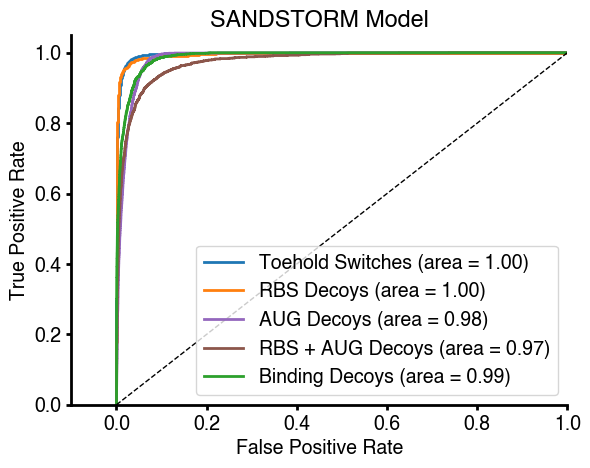

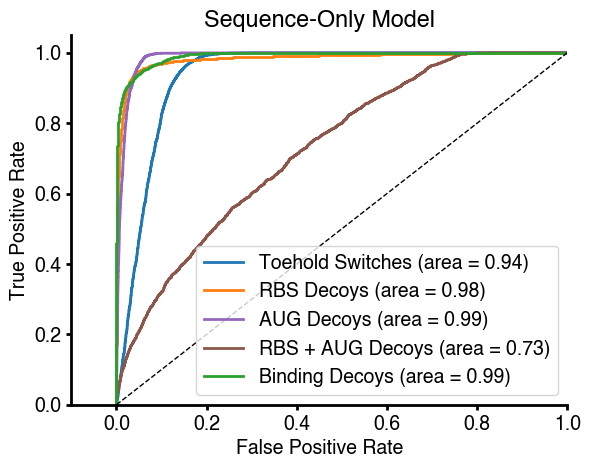

In [66]:
from sklearn.metrics import roc_curve
from itertools import cycle
n_classes=5
lw = 2
fs = 14






# Plot all ROC curves
plt.figure()

plt.rcParams.update({'font.size': fs,'font.family':'Helvetica'})
colors = ['C0','C1','C4','C5','C2','C3']

plt.plot(fpr_e[0],tpr_e[0],lw=lw,label="Toehold Switches (area = {0:0.2f})".format(roc_auc_e[0]),color=colors[0])
plt.plot(fpr_e[1],tpr_e[1],lw=lw,label="RBS Decoys (area = {0:0.2f})".format(roc_auc_e[1]),color=colors[1])
plt.plot(fpr_e[2],tpr_e[2],lw=lw,label="AUG Decoys (area = {0:0.2f})".format(roc_auc_e[2]),color=colors[2])
plt.plot(fpr_e[3],tpr_e[3],lw=lw,label="RBS + AUG Decoys (area = {0:0.2f})".format(roc_auc_e[3]),color=colors[3])
plt.plot(fpr_e[4],tpr_e[4],lw=lw,label="Binding Decoys (area = {0:0.2f})".format(roc_auc_e[4]),color=colors[4])

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SANDSTORM Model")
plt.legend(loc="lower right")
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(lw)
plt.subplot().spines['bottom'].set_linewidth(lw)
plt.subplot().xaxis.set_tick_params(width=2)
plt.subplot().yaxis.set_tick_params(width=2)
# plt.savefig('../figures/sequence_and_structure_only_roc.svg',transparent=True)



plt.figure()

plt.rcParams.update({'font.size': fs,'font.family':'Helvetica'})
# colors = cycle(["aqua", "darkorange", "cornflowerblue"])

plt.plot(fpr_s[0],tpr_s[0],lw=lw,label="Toehold Switches (area = {0:0.2f})".format(roc_auc_s[0]),color=colors[0])
plt.plot(fpr_s[1],tpr_s[1],lw=lw,label="RBS Decoys (area = {0:0.2f})".format(roc_auc_s[1]),color=colors[1])
plt.plot(fpr_s[2],tpr_s[2],lw=lw,label="AUG Decoys (area = {0:0.2f})".format(roc_auc_s[2]),color=colors[2])
plt.plot(fpr_s[3],tpr_s[3],lw=lw,label="RBS + AUG Decoys (area = {0:0.2f})".format(roc_auc_s[3]),color=colors[3])
plt.plot(fpr_s[4],tpr_s[4],lw=lw,label="Binding Decoys (area = {0:0.2f})".format(roc_auc_s[4]),color=colors[4])

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Sequence-Only Model")
plt.legend(loc="lower right")
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(lw)
plt.subplot().spines['bottom'].set_linewidth(lw)
plt.subplot().xaxis.set_tick_params(width=2)
plt.subplot().yaxis.set_tick_params(width=2)
# plt.savefig('../figures/sequence_only_roc.svg',transparent=True)

In [64]:
import datetime
today = datetime.date.today()
# discriminator_ensemble.save('models/binary_classifier_%s'%(today))